In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from modSAR.datasource import ChEMBLApiDataSource
from modSAR.cdk_utils import JavaCDKBridge

%matplotlib inline
from plotnine import *

# Acquiring Data from ChEMBL

The class `ChEMBLApiDataSource` interacts with the [ChEMBL webresource client API](https://github.com/chembl/chembl_webresource_client) to download bioactivities from ChEMBL. 

We must pass the ID of the target protein and the standard types we are interested in and the class will compile the compounds requested into a pandas DataFrame `bioactivities_df`:

In [11]:
from chembl_webresource_client.new_client import new_client
activity = new_client.activity
result = activity.filter(target_chembl_id='CHEMBL202', assay_type__iregex='(B|F)')

In [44]:
result[0]

{'activity_comment': None,
 'activity_id': 1958630,
 'activity_properties': [],
 'assay_chembl_id': 'CHEMBL891091',
 'assay_description': 'Inhibition of human NAD kinase at 1 mM',
 'assay_type': 'B',
 'bao_endpoint': 'BAO_0000201',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'canonical_smiles': 'BrCC(=O)c1ccncc1',
 'data_validity_comment': None,
 'data_validity_description': None,
 'document_chembl_id': 'CHEMBL1147029',
 'document_journal': 'Bioorg. Med. Chem. Lett.',
 'document_year': 2007,
 'ligand_efficiency': None,
 'molecule_chembl_id': 'CHEMBL232633',
 'molecule_pref_name': None,
 'parent_molecule_chembl_id': 'CHEMBL232633',
 'pchembl_value': None,
 'potential_duplicate': False,
 'qudt_units': 'http://qudt.org/vocab/unit#Percent',
 'record_id': 648422,
 'relation': '=',
 'src_id': 1,
 'standard_flag': True,
 'standard_relation': '=',
 'standard_text_value': None,
 'standard_type': 'Inhibition',
 'standard_units': '%',
 'standard_upper_value': None,
 'sta

In [12]:
chembl_data_source = ChEMBLApiDataSource(target_id='CHEMBL202', standard_types=['IC50', 'Ki'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In total, the API returned 1500+ bioactivities registered as hDHFR ligands [CHEMBL202](https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL202):

In [14]:
chembl_data_source

ChEMBLApiDataSource object
  target_id: CHEMBL202
  bioactivities: 1580
  standard_types: ['Ki' 'IC50' 'Log 1/Ki app' 'IC50/[E]' 'Ratio IC50']

Here is a peak of the data returned from ChEMBL API:

In [13]:
chembl_data_source.bioactivities_df.head()

,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ligand_efficiency_bei,ligand_efficiency_le,ligand_efficiency_lle,ligand_efficiency_sei,activity_properties,ligand_efficiency
0,None,40879,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL7130,None,CHEMBL7130,7.03,False,http://www.openphacts.org/units/Nanomolar,347068,=,1,True,=,None,Ki,nM,None,93.33,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.03,27.93,0.56,5.5,8.79,NaN,NaN
1,None,42137,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2ccc(CCCCc3ccc(cc3Cl)S(=O...,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL33697,None,CHEMBL33697,7.65,False,http://www.openphacts.org/units/Nanomolar,347071,=,1,True,=,None,Ki,nM,None,22.39,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.65,15.29,0.33,3.25,6.7,NaN,NaN
2,None,42149,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(OCC34CC5CC(CC(C5)C3...,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL281618,None,CHEMBL281618,6.11,False,http://www.openphacts.org/units/Nanomolar,347091,=,1,True,=,None,Ki,nM,None,776.25,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,6.11,16.01,0.3,2.64,6.85,NaN,NaN
3,None,45682,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL22,TRIMETHOPRIM,CHEMBL22,6.71,False,http://www.openphacts.org/units/Nanomolar,347106,=,1,True,=,None,Ki,nM,None,194.98,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,6.71,23.11,0.44,5.45,6.36,NaN,NaN
4,None,46931,CHEMBL666808,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(SCc3ccccc3)c2,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL20975,None,CHEMBL20975,7.37,False,http://www.openphacts.org/units/Nanomolar,347115,=,1,True,=,None,Ki,nM,None,42.66,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.37,21.71,0.42,4.21,9.21,NaN,NaN


The distribution of standard activity types in the data set:

In [15]:
chembl_data_source.bioactivities_df['standard_type'].value_counts()

IC50            1127
Ki               405
Log 1/Ki app      38
IC50/[E]           8
Ratio IC50         2
Name: standard_type, dtype: int64

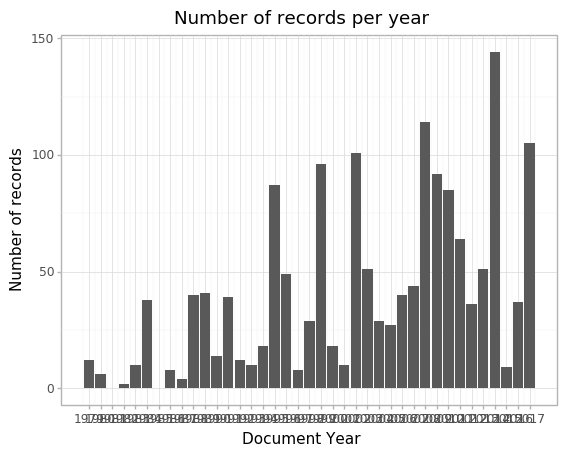

<ggplot: (8746091867063)>

In [16]:
plot_df = chembl_data_source.bioactivities_df
plot_df['document_year'] = plot_df['document_year'].astype('int')

ggplot(plot_df, aes(x='document_year')) + \
    geom_bar() + theme_light() + \
    scale_x_continuous(breaks=range(min(plot_df['document_year']), max(plot_df['document_year']) + 1)) + \
    xlab("Document Year") + ylab("Number of records") + \
    ggtitle("Number of records per year")

In [17]:
chembl_data_source.bioactivities_df['document_journal'].value_counts()

J. Med. Chem.                    989
Bioorg. Med. Chem.               165
Bioorg. Med. Chem. Lett.         135
Eur J Med Chem                    78
Eur. J. Med. Chem.                65
Antimicrob. Agents Chemother.     22
J Med Chem                        20
Med Chem Res                      12
ACS Med. Chem. Lett.              12
MedChemComm                        7
Bioorg Med Chem Lett               7
J. Nat. Prod.                      1
Name: document_journal, dtype: int64

# Reading Molecules with RDKit

In [18]:
chembl_data_source.bioactivities_df.iloc[0]['canonical_smiles']

'CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2'

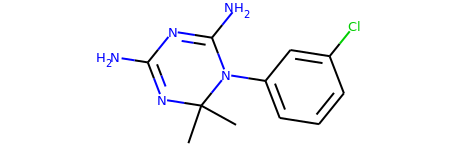

In [19]:
m = Chem.MolFromSmiles(chembl_data_source.bioactivities_df.iloc[0]['canonical_smiles'])
m

## Molecular Descriptors

In [32]:
dir(Chem.Descriptors)

['BalabanJ',
 'BertzCT',
 'Chem',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'ExactMolWt',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomCount',
 'HeavyAtomMolWt',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'MaxAbsEStateIndex',
 'MaxAbsPartialCharge',
 'MaxEStateIndex',
 'MaxPartialCharge',
 'MinAbsEStateIndex',
 'MinAbsPartialCharge',
 'MinEStateIndex',
 'MinPartialCharge',
 'MolLogP',
 'MolMR',
 'MolWt',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRadicalElectrons',
 'N

In [21]:
def calc_descriptor(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return pd.Series({'heavyAtomCount': Chem.Descriptors.HeavyAtomCount(mol),
                      'ExactMolWt': Chem.Descriptors.ExactMolWt(mol),
                      'MolLogP': Chem.Descriptors.MolLogP(mol)})

aux_df = chembl_data_source.bioactivities_df['canonical_smiles'].apply(calc_descriptor)
aux_df.index = chembl_data_source.bioactivities_df['parent_molecule_chembl_id']
aux_df['pchembl_value'] = chembl_data_source.bioactivities_df['pchembl_value'].values
aux_df

,heavyAtomCount,ExactMolWt,MolLogP,pchembl_value
parent_molecule_chembl_id,,,,
CHEMBL7130,17.0,251.093773,1.52550,7.03
CHEMBL33697,32.0,499.101180,4.40250,7.65
CHEMBL281618,28.0,381.252861,3.46730,6.11
CHEMBL22,21.0,290.137890,1.25760,6.71
CHEMBL20975,24.0,339.151767,3.16440,7.37
CHEMBL20587,25.0,343.273596,4.16520,6.66
CHEMBL6742,16.0,217.132745,0.87210,5.78
CHEMBL176987,24.0,329.257946,3.77510,6.01
CHEMBL21254,28.0,385.320546,5.33550,6.52


In [22]:
dir(Chem.Descriptors)

['BalabanJ',
 'BertzCT',
 'Chem',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'ExactMolWt',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomCount',
 'HeavyAtomMolWt',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'MaxAbsEStateIndex',
 'MaxAbsPartialCharge',
 'MaxEStateIndex',
 'MaxPartialCharge',
 'MinAbsEStateIndex',
 'MinAbsPartialCharge',
 'MinEStateIndex',
 'MinPartialCharge',
 'MolLogP',
 'MolMR',
 'MolWt',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRadicalElectrons',
 'N

# Preprocessing

Methods in `Preprocessing` class filters out invalid/more inaccurate entries for QSAR modelling. In summary, the preprocessing step for ChEMBL data involves:

- Select only valid entries as indicated by the column `data_validity_comment`
- Select only entries where relation is of type equality (e.g.: IC50 = 30nM), as indicated by column `relation`
- Handle duplicated entries
- Remove data marked as outliers

To obtain a preprocessed dataset, either use `chembl_data_source.get_qsar_dataset()` method or the function `build_qsar_dataset(chembl_data_source)`:


In [14]:
qsar_dataset = chembl_data_source.get_qsar_dataset()

CDK Bridge process running
CDK Bridge process running
Cleaning up JavaGateway


Py4JNetworkError: Gateway is not connected.

Because of this preprocessing step, the resulting data set has fewer entries:

In [ ]:
import altair as alt

alt.renderers.enable('notebook')

chart = alt.Chart(preprocessed_df).mark_bar().encode(
    x=alt.X("median_pchembl_value", bin=True, title='Median pChEMBL value'),
    y='count()',
    tooltip=['count()'],
).properties(
    title='Activities distribution'
)

chart

![Activities distribution](fig/notebook01/fig01_activities_distribution.png)

# Molecular Descriptors

After removing invalid and handling duplicated entries, we use Chemistry Development Kit ([CDK v2.2](https://github.com/cdk/cdk)) to calculate molecular descriptors on the resulting dataset.

In order to run CDK in Python, we need to establish a bridge with the Java programming language:

In [16]:
java_cdk_bridge = JavaCDKBridge()
java_cdk_bridge.start_cdk_java_bridge()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:25333)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 958, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1096, in start
    self.socket.connect((self.address, self.port))
  File "/opt/conda/lib/python3.6/site-packages/gevent/_socket3.py", line 335, in connect
    raise error(err, strerror(err))
ConnectionRefusedError: [Errno 111] Connection refused


Cleaning up JavaGateway
Compiling CDKBridge
Starting CDKBridge


Now, we can instantiate classes and manipulate CDK Java objects from within Python:

In [17]:
gateway = java_cdk_bridge.gateway
cdk = gateway.jvm.org.openscience.cdk

builder = cdk.DefaultChemObjectBuilder.getInstance()
smiles_parser = cdk.smiles.SmilesParser(builder)
builder

JavaObject id=o0

In [ ]:
from py4j.java_gateway import JavaGateway, GatewayParameters
JavaGateway(gateway_parameters=GatewayParameters(auto_convert=True))

**DESCRIPTORS LIST**

For convenience, we saved a list of all molecular descriptors classes in CDK in the `descriptors_list.csv`. 

In [ ]:
descriptors_list = pd.read_csv('/mnt/data/descriptors_list.csv')

def remove_prefix(java_class_name):
    return java_class_name.replace('org.openscience.', '') + '()'

descriptors_list['object_invocation'] = descriptors_list['descriptorClass'].apply(remove_prefix)
descriptors_list

We can calculate and combine all molecular descriptors in a DataFrame: 

In [ ]:
import py4j

def calculate_all_descriptors(data, descriptors_df):
    mol_container = smiles_parser.parseSmiles(data['canonical_smiles'])
    dict_descriptors = {}
    for i in range(descriptors_df.shape[0]):
        descriptor = eval(descriptors_df.iloc[i]['object_invocation'])
        descriptor.initialise(builder)
        descriptor_names = [desc_name for desc_name in descriptor.getDescriptorNames()]
        try:
            descriptor_values = descriptor.calculate(mol_container).getValue().toString().split(',')
        except Exception as e:
            print(e)
        
        dict_descriptors.update({descriptor_names[j]: descriptor_values[j] 
                                 for j in range(len(descriptor_names))})
    
    result_df = pd.DataFrame(dict_descriptors, index=[data['parent_molecule_chembl_id']])
    return result_df

pd.concat([
    calculate_all_descriptors(preprocessed_df.iloc[1], descriptors_list),
    calculate_all_descriptors(preprocessed_df.iloc[0], descriptors_list)], axis=0)

\#TODO: Errors

In [ ]:
smiles_parser.parseSmiles(preprocessed_df.iloc[351]['canonical_smiles'])

In [ ]:
preprocessed_df.head(10).apply(calculate_all_descriptors, axis=1, descriptors_df=descriptors_list)

In [ ]:
py4j.java_gateway.get_field(descriptor, 'CHECK_RING_SYSTEM')

In [ ]:
[f for f in descriptor.getParameters()]

In [ ]:
gateway.jvm.java.lang.Object()

In [ ]:
descriptor.setParameters(['false'])

In [ ]:
descriptor = cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor()
mol_container = smiles_parser.parseSmiles(preprocessed_df.iloc[2]['canonical_smiles'])
descriptor.calculate(mol_container).getValue().toString().split(',')

In [ ]:
m = Chem.MolFromSmiles(preprocessed_df.iloc[3]['canonical_smiles'])
m

In [ ]:
AllChem.CalcKappa1(m)

In [ ]:
result_df.columns.tolist()